<h1 style="font-family:Corbel Light; color:#e54b87">Projet 3: Concevez une application au service de la sant√© publique </h1>

<h2 style="font-family:Corbel Light; color:#737373">Contexte</h2>

L‚Äôagence Sant√© Publique France a lanc√© un appel √† projet autour des probl√©matiques alimentaires. Elle souhaite trouver des id√©es innovantes d‚Äôapplications pour am√©liorer l‚Äôalimentation de la population fran√ßaise. 

<h2 style="font-family:Corbel Light; color:#737373">Mission</h2>

Proposer une id√©e d‚Äôapplication et mener une analyse exploratoire pour v√©rifier que notre id√©e est r√©alisable √† partir du jeu de donn√©es nutritionnelles mis √† notre disposition.

Id√©e d'application √©tudi√©e : permettre √† l‚Äôutilisateur de scanner le code barre d‚Äôun produit pour se voir proposer des produits de la m√™me famille d‚Äôaliments, mais avec la meilleure valeur nutritionnelle possible et le plus faible degr√© de transformation possible. 

<h2 style="font-family:Corbel Light; color:#737373">Requirements</h2>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from scipy import stats as st
import matplotlib
from matplotlib import pyplot as plt
import sklearn
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import datetime as dt
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import toolbox
import textwrap
import nltk
import math
import skimage
import ssl
import re

%matplotlib inline
pd.options.display.float_format = '{:_.2f}'.format

In [2]:
python_version = !python -V
print('python version :', python_version, '\n')

print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('scipy version : ', scipy.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('seaborn version : ', sns.__version__, '\n')
print('scikit-learn version : ', sklearn.__version__, '\n')
print('nlkt version : ', nltk.__version__, '\n')
print('skimage version : ', skimage.__version__, '\n')
print('statsmodels version : ', statsmodels.__version__, '\n')

python version : ['Python 3.9.12'] 

pandas version :  1.4.2 

numpy version :  1.21.5 

scipy version :  1.9.1 

matplotlib version :  3.5.1 

seaborn version :  0.12.1 

scikit-learn version :  1.1.3 

nlkt version :  3.7 

skimage version :  0.19.2 

statsmodels version :  0.13.2 



**Versions utilis√©es :**

- python : Python 3.9.12
- statsmodels version :  0.13.2 
- skimage version :  0.19.2 
- scikit-learn  :  1.1.3  
- matplotlib :  3.5.1 
- seaborn    :  0.12.1
- nlkt version :  3.7 
- numpy  :  1.21.5 
- pandas :  1.4.2
- scipy  :  1.9.1 

<h2 style="font-family:Corbel Light; color:#737373"><span style="color:#e54b87">√âtape 2</span> : Analyse exploratoire de donn√©es</h2>

<h3 style="font-family:Corbel Light; color:#737373">Inspection des donn√©es</h3>

In [3]:
food_data = pd.read_csv('food_subset_clean.csv',
                        parse_dates=['last_modified_datetime', 'created_datetime'])
food_data.shape

(235562, 20)

In [4]:
food_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235562 entries, 0 to 235561
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   code                     235562 non-null  float64       
 1   product_name             235562 non-null  object        
 2   last_modified_datetime   235562 non-null  datetime64[ns]
 3   created_datetime         235561 non-null  datetime64[ns]
 4   nutrition-score-fr_100g  214678 non-null  float64       
 5   nutrition_grade_fr       235562 non-null  object        
 6   saturated-fat_100g       235562 non-null  float64       
 7   sugars_100g              235562 non-null  float64       
 8   energy_100g              235562 non-null  float64       
 9   sodium_100g              235562 non-null  float64       
 10  salt_100g                235562 non-null  float64       
 11  proteins_100g            235562 non-null  float64       
 12  fiber_100g      

In [5]:
toolbox.missing_values_by_column(food_data)

VARIABLES  Number of Missing Values  Missing Values (%)
0                      code                         0                0.00
17                  creator                         0                0.00
12               fiber_100g                         0                0.00
11            proteins_100g                         0                0.00
10                salt_100g                         0                0.00
8               energy_100g                         0                0.00
7               sugars_100g                         0                0.00
9               sodium_100g                         0                0.00
5        nutrition_grade_fr                         0                0.00
2    last_modified_datetime                         0                0.00
1              product_name                         0                0.00
6        saturated-fat_100g                         0                0.00
3          created_datetime                         1                0.00
16           countries_tags                        83                0.04
4   nutrition-score-fr_100g                     20884                8.87
18              additives_n                     29116               12.36
19                additives                     29139               12.37
14            pnns_groups_2                    167651               71.17
13            pnns_groups_1                    170429               72.35
15          image_small_url                    178611               75.82

Dictionnaire utilis√© pour mettre les pays en anglais

In [6]:
countries_dict = {'espagne': 'spain', 'spanien': 'spain', 'spanyolorszag': 'spain',
                  'deutschland': 'germany', 'allemagne': 'germany', 'nemetorszag': 'germany',
                  'franciaorszag': 'france', 'frankrijk': 'france', 'frankreich': 'france', 'frankrike': 'france',
                  'magyarorszag': 'hungary',
                  'nagy-britannia': 'united-kingdom', 'royaume-uni': 'united-kingdom',
                  'vereinigtes-konigreich': 'united-kingdom', '‡∏™‡∏´‡∏£‡∏≤‡∏ä‡∏≠‡∏≤‡∏ì‡∏≤‡∏à‡∏±‡∏Å‡∏£': 'united-kingdom',
                  'portugalia': 'portugal',
                  'weltweit': 'world',
                  'pays-bas': 'netherlands', 'nederland': 'netherlands', 'niederlande': 'netherlands',
                  'belgien': 'belgium', 'belgique': 'belgium', 'belgie': 'belgium',
                  'republik-china': 'china', 'republique-de-chine': 'china',
                  'schweiz': 'switzerland', 'svajc': 'switzerland', 'zwitserland': 'switzerland',
                  'sverige': 'sweden', 'zweden': 'sweden',
                  'danemark': 'denmark', 'denemarken': 'denmark',
                  'ÿßŸÑÿ•ŸÖÿßÿ±ÿßÿ™-ÿßŸÑÿπÿ±ÿ®Ÿäÿ©-ÿßŸÑŸÖÿ™ÿ≠ÿØÿ©': 'united-arab-emirates',
                  'australie': 'australia', '‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡∏≠‡∏≠‡∏™‡πÄ‡∏ï‡∏£‡πÄ‡∏•‡∏µ‡∏¢': 'australia',
                  'etats-unis': 'united-states',
                  'az…ôrbaycan': 'azerbaijan',
                  'ÿ≥ŸÑÿ∑ŸÜÿ©-ÿπŸÖÿßŸÜ': 'oman',
                  '‡§≠‡§æ‡§∞‡§§': 'india',
                  'ÿßŸÑÿ≥ÿπŸàÿØŸäÿ©': 'saudi-arabia',
                  'È¶ôÊ∏Ø': 'hong-kong',
                  '–∫–∞–∑–∞—Ö—Å—Ç–∞–Ω': 'kazakhstan',
                  '‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡πÑ‡∏ó‡∏¢': 'thailand',
                  'Êó•Êú¨': 'japan',
                  'czech': 'czech-republic', 'tschechien': 'czech-republic'
                  }

<h3 style="font-family:Corbel Light; color:#737373">Analyses Univari√©es</h3>

<h4 style="font-family:Corbel Light; color:#e54b87">Variables qualitatives</h4>

Q: De quand datent nos donn√©es ? 

√Ä l'aide d'un histogramme on visualise l'√©volution dans le temps du nombre de produits ajout√©s sur le site par an

R : Il semblerait que la majorit√© des donn√©es datent de 2017 (rmq: nutriscore mis en place en 2017)

In [7]:
food_data = food_data.sort_values('created_datetime', ascending=False)

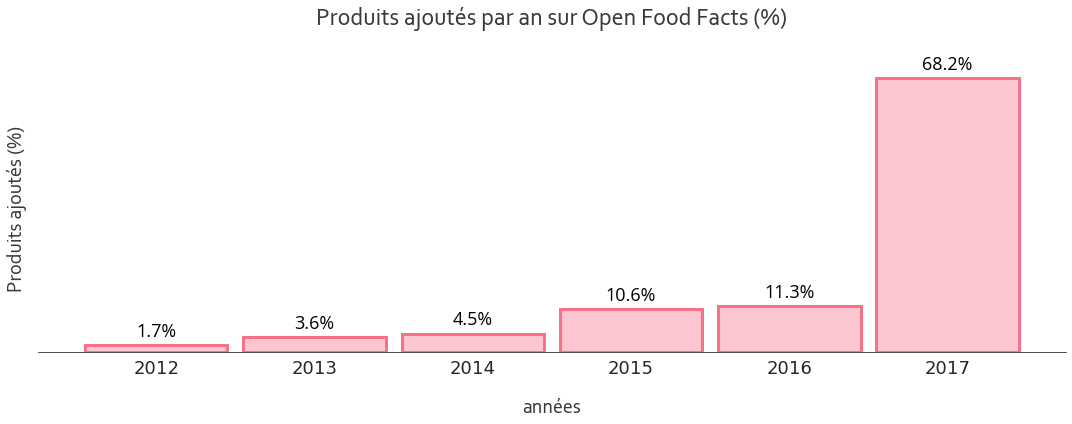

In [8]:
color = sns.color_palette("husl", 8)[0]
titles = {'chart_title': 'Produits ajout√©s par an sur Open Food Facts (%)',
          'y_title': 'Produits ajout√©s (%)',
          'x_title': 'ann√©es'}

toolbox.plot_empirical_distribution(food_data['created_datetime'].dt.year,
                                    color, titles, (15, 6))

***

***

Q: Dans quels pays sont disponibles les produits de notre jeu de donn√©es ? 

√Ä l'aide d'un histogramme on visualise la distribution empirique de la variable 'countries_tags'

R: Les produits du jeu de donn√©es semblent √™tre majoritairement en vente aux Etats-unis et en France

(rmq: nutriscore utilis√© en France, Belgique, Allemagne, Luxembourg, Pays-Bas, Espagne et Suisse)

In [9]:
countries_frequency_df = toolbox.count_countries(food_data, 'countries_tags', 0.01, countries_dict)

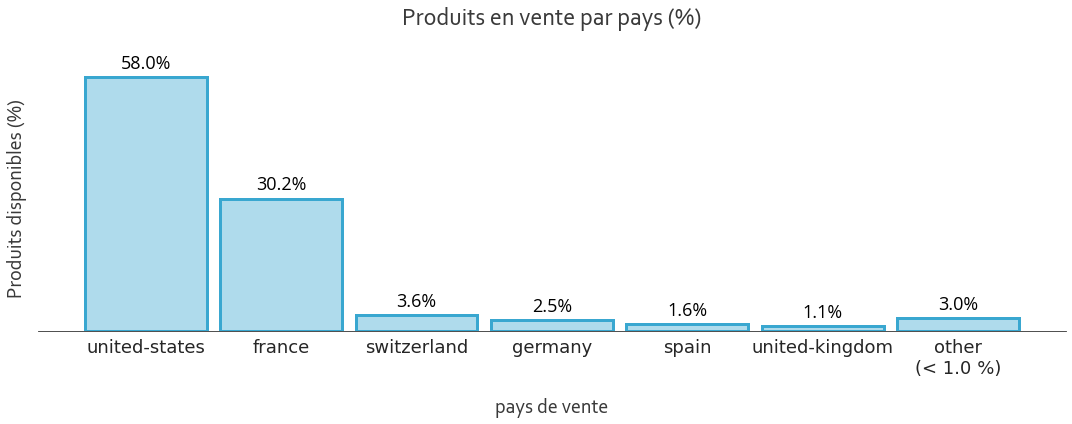

In [10]:
color = sns.color_palette("husl", 8)[5]
titles = {'chart_title': 'Produits en vente par pays (%)',
          'y_title': 'Produits disponibles (%)',
          'x_title': 'pays de vente'}

toolbox.plot_empirical_distribution(countries_frequency_df['countries'], color, titles, (15, 6))

***

***

Q: Qui sont les personnes qui ont renseign√© les donn√©es sur Open Food Facts (que des particuliers ?)

√Ä l'aide d'un diagramme √† barre on visualise la distribution empirique de la variable 'creators'

In [11]:
creator_frequency_df = toolbox.build_frequency_df_with_thresh(food_data,
                                                              'creator',
                                                              0.01,
                                                              'autres (contribution < {} %)')

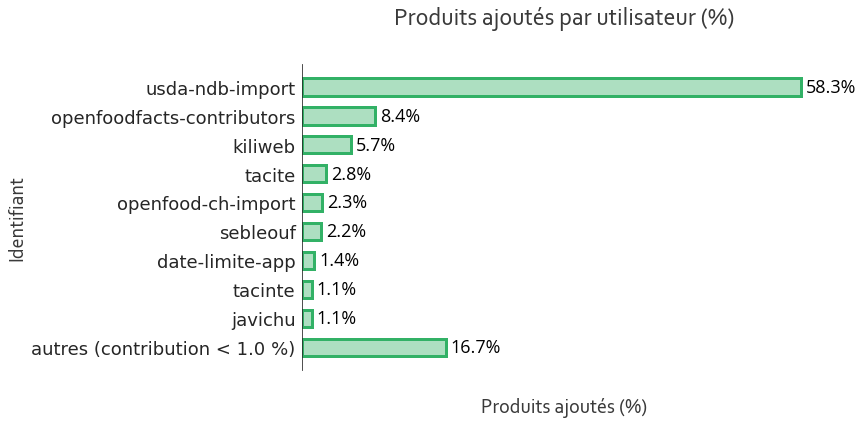

In [12]:
color = sns.color_palette("husl", 8)[3]
titles = {'chart_title': 'Produits ajout√©s par utilisateur (%)',
          'y_title': 'Identifiant',
          'x_title': 'Produits ajout√©s (%)'}

toolbox.plot_empirical_distribution(creator_frequency_df['creator'], color, titles, (12, 6), vertical=False)

R: 58% des donn√©es ont √©t√© import√©es par le D√©partement de l'Agriculture des Etats Unis (USDA) (un peu surprenant OpenFoodFacts et le Nutri-score sont des initiatives fran√ßaises) 

Les donn√©es ont √©t√© import√©es en une fois (le 09/10 mars 2017) pour des produits vendus aux √©tats-unis (sauf 9). Ce qui explique pourquoi la majorit√© des donn√©es concernent des produits vendus aux √©tats-unis. 

In [13]:
usda_data = food_data.loc[food_data['creator'] == 'usda-ndb-import'].copy()

In [14]:
usda_data['created_datetime'].unique()

array(['2017-03-10T00:00:00.000000000', '2017-03-09T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [15]:
usda_data['countries_tags'].value_counts()

en:united-states             137281
en:france                         9
en:spain,en:united-states         1
Name: countries_tags, dtype: int64

***

***

<h4 style="font-family:Corbel Light; color:#e54b87">Variables quantitatives</h4>

In [16]:
columns_100g = toolbox.get_columns_contains(food_data, '_100g', ['nutrition-score-fr_100g'])
food_data.describe().loc[:, columns_100g]

saturated-fat_100g  sugars_100g  energy_100g  sodium_100g  salt_100g  \
count          235_562.00   235_562.00   235_562.00   235_562.00 235_562.00   
mean                 4.94        14.84     1_159.77         0.49       1.25   
std                  7.34        19.57       748.96         1.55       3.91   
min                  0.00         0.00         0.00         0.00       0.00   
25%                  0.00         1.40       444.00         0.05       0.13   
50%                  2.01         5.13     1_151.00         0.27       0.68   
75%                  7.00        22.39     1_674.00         0.55       1.40   
max                100.00       100.00     3_764.00        83.00     100.00   

       proteins_100g  fiber_100g  
count     235_562.00  235_562.00  
mean            7.74        2.29  
std             7.98        4.18  
min             0.00        0.00  
25%             2.10        0.00  
50%             5.60        0.60  
75%            10.71        3.20  
max           100.00      100.00

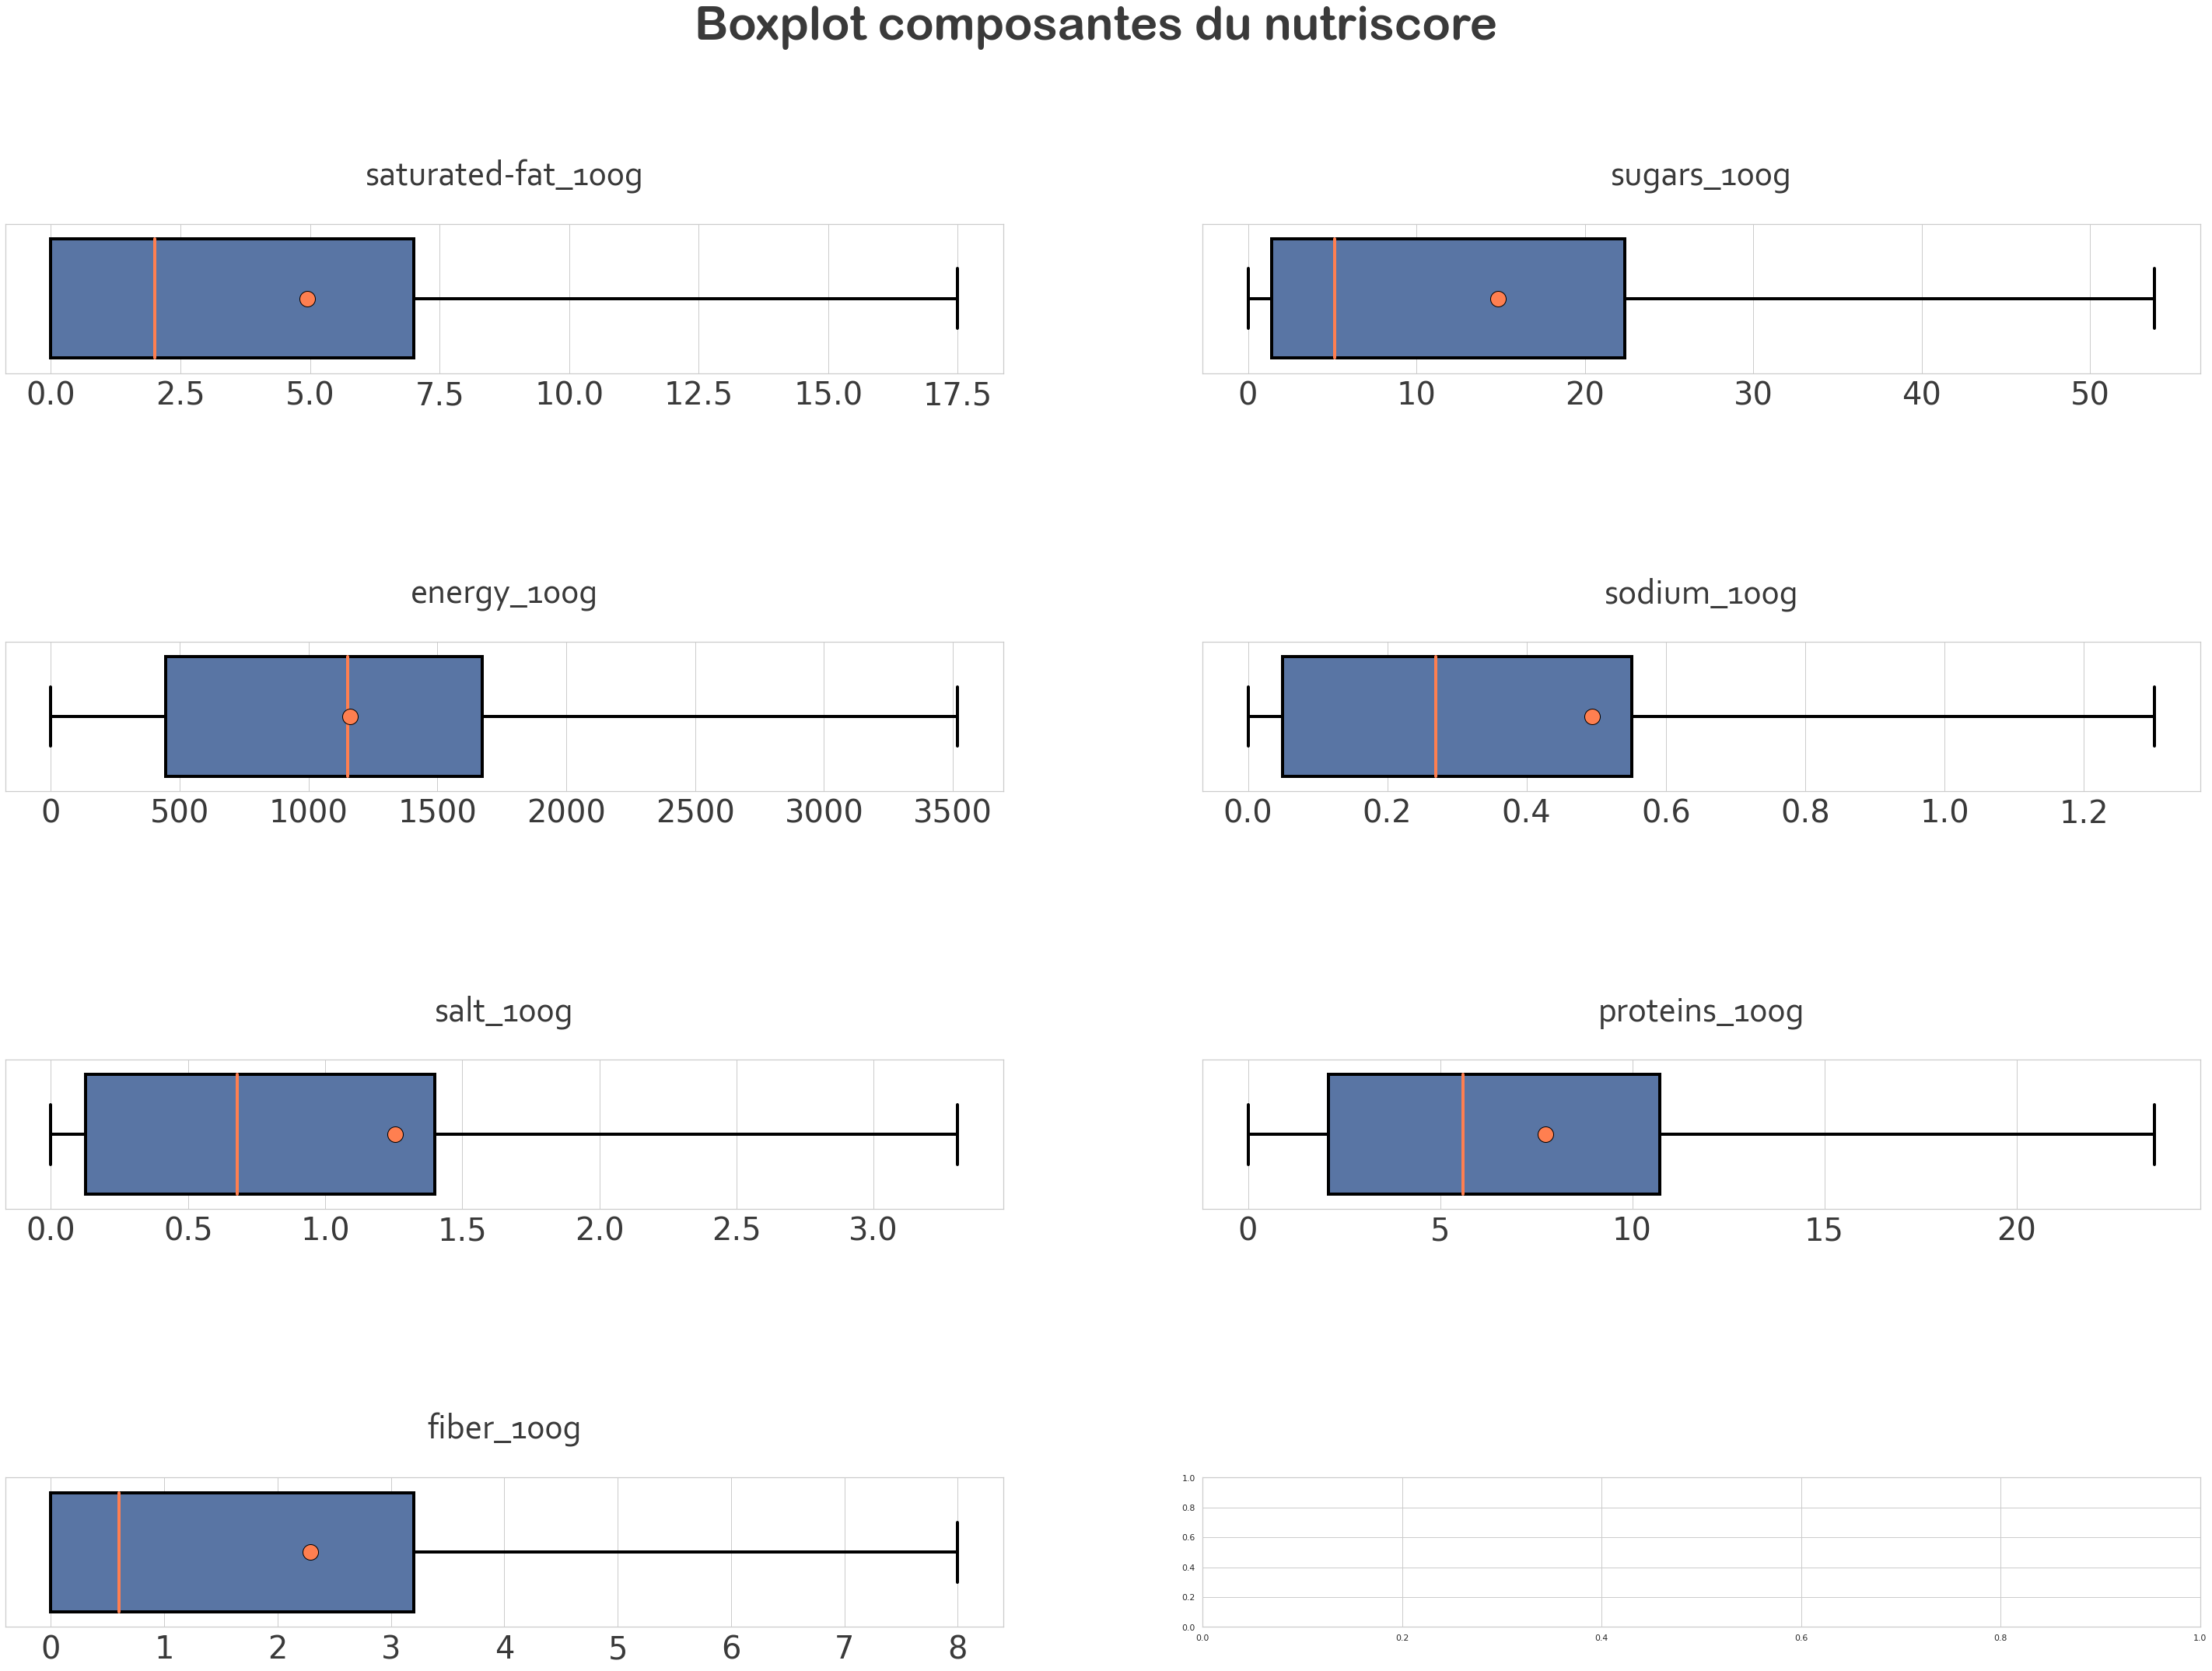

In [17]:
toolbox.plot_boxplot_by_dimension(food_data, columns_100g, 2, 'composantes du nutriscore', (40, 30))

<h3 style="font-family:Corbel Light; color:#737373">Analyses Bivari√©es</h3>

<h4 style="font-family:Corbel Light; color:#e54b87">Variable qualitative vs qualitative</h4>

On veut √©tudier la relation entre les familles d'aliments (pnns1) et le nutrigrade

Q: Certaines cat√©gories de produits ont-elles toujours le m√™me nutrigrade ?

In [18]:
titles = {'chart_title': 'Tableau de contingence',
          'y_title': 'Familles d\'aliments',
          'x_title': 'nutrigrades'}

Statistique du chi2: 39193.015827003735


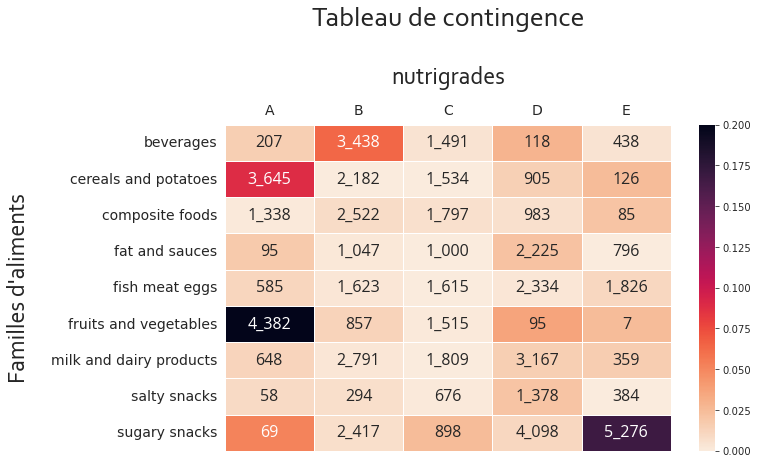

In [19]:
food_data['nutrition_grade_fr'] = food_data['nutrition_grade_fr'].str.upper()
contingence_table = pd.crosstab(food_data['pnns_groups_1'],
                                food_data['nutrition_grade_fr'],
                                dropna=True,
                                margins=True,
                                margins_name="Total")

xi_table, xi_n = toolbox.build_xi_table(contingence_table)
print('Statistique du chi2:', xi_n)

toolbox.plot_heatmap(xi_table.iloc[:-1, :-1],
                     round(xi_table.max().max(), 1),
                     titles,
                     (10, 6),
                     'd',
                     annotation=contingence_table.iloc[:-1, :-1])

Test d'ind√©pendance du chi-2 : 

- H0 : les variables sont ind√©pendantes
- H1 : les variables sont corr√©l√©es

On fixe un niveau de test √† 1% et on calcule la p_value. Si p_value < 1% alors on peut rejeter H0.

In [20]:
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(contingence_table)
print('Statistique du chi2:', st_chi2, '\np_value:', st_p)

Statistique du chi2: 39193.015827003735 
p_value: 0.0


On retrouve la statistique du chi2 calcul√©e √† la main. 
 
On rejette tr√®s largement l'hypoth√®se d'ind√©pendance des deux variables au niveau de test 1%

***

***

<h4 style="font-family:Corbel Light; color:#e54b87">Variable qualitative vs quantitative</h4>

√Ä l'aide d'un histogramme on fait ressortir la distribution des nutri-scores en fonction des nutri-grades

Nutri-grades : plut√¥t bien r√©partis, un peu plus de D que des autres. Environ 50% A, B, E et 50% D, C

In [21]:
mask_gp2 = ~food_data['pnns_groups_2'].isnull()
mask_nutriscore = ~food_data['nutrition-score-fr_100g'].isnull()
food_nutri = food_data.loc[(mask_gp2) & (mask_nutriscore)].sort_values('nutrition_grade_fr')

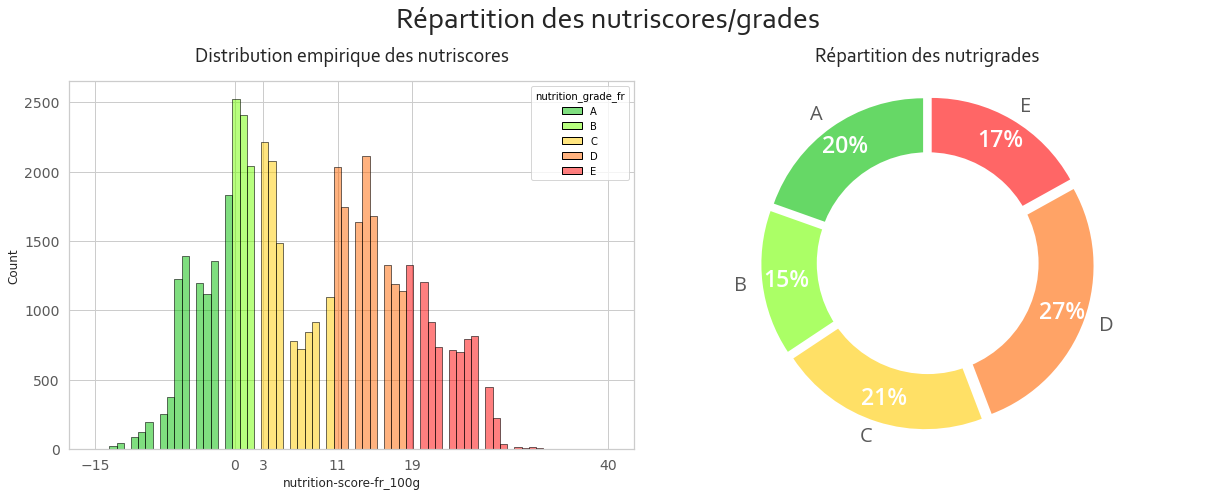

In [22]:
titles = {'suptitle': 'R√©partition des nutriscores/grades',
          'hist_title': 'Distribution empirique des nutriscores',
          'donut_title': 'R√©partition des nutrigrades'}

palette_nutriscore = ['#00BF00', '#73FF00', '#FFCC00', '#FF6600', '#FF0000']

toolbox.plot_hist_and_donut(food_nutri, 'nutrition-score-fr_100g',
                            'nutrition_grade_fr', palette_nutriscore, '#595959', titles, (17, 7))

***

***

On va √©tudier l'influence du facteur g√©ographique sur la valeur nutritionnelle des produits vendus (cela n'aurait pas de sens de comparer des produits de cat√©gories diff√©rentes et il semble difficile de construire des √©chantillons avec la m√™me proportion de cat√©gories pour chaque pays, donc on compare juste les produits de la cat√©gorie 'sauces et vinaigrettes').

On prend les 5 pays les plus repr√©sent√©s : Etats-Unis, France, Suisses, Espagne, Allemagne

In [51]:
food_data_sauces = food_data.loc[(mask_nutriscore) & (food_data['pnns_groups_2'] == 'dressings and sauces')]

In [52]:
list_france = ['france', 'franciaorszag', 'frankrijk', 'frankreich', 'frankrike']
list_usa = ['united-states', 'etats-unis']
list_spain = ['spain', 'espagne',  'spanien', 'spanyolorszag']
list_germany = ['germany', 'deutschland',  'allemagne', 'nemetorszag']
list_swiss = ['switzerland', 'schweiz',  'svajc', 'zwitserland']

list_countries = [list_france, list_usa, list_spain, list_germany, list_swiss]

country_df = toolbox.extract_country_data(food_data_sauces, 'countries_tags', list_countries, 'nutrition-score-fr_100g')

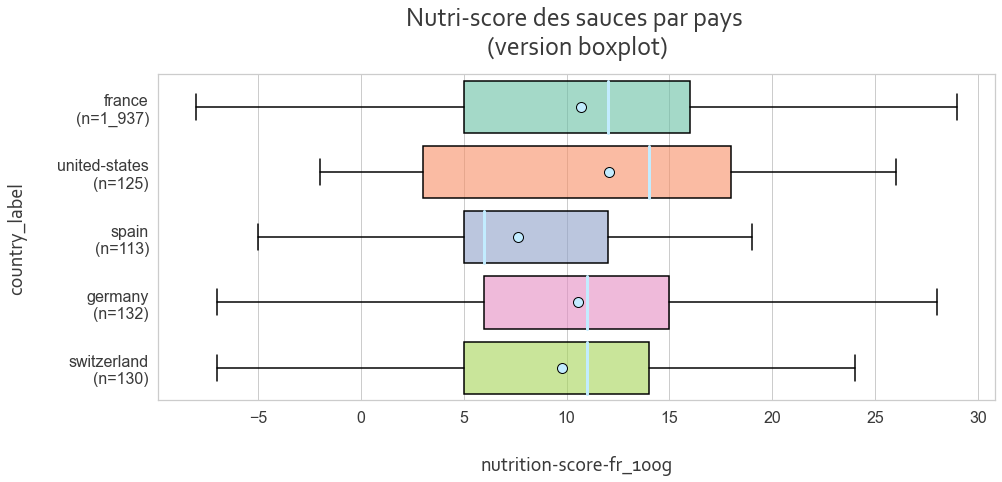

In [25]:
toolbox.plot_boxplot(country_df,
                     'nutrition-score-fr_100g',
                     'Nutri-score des sauces par pays \n(version boxplot)',
                     (15, 6),
                     'country_label')

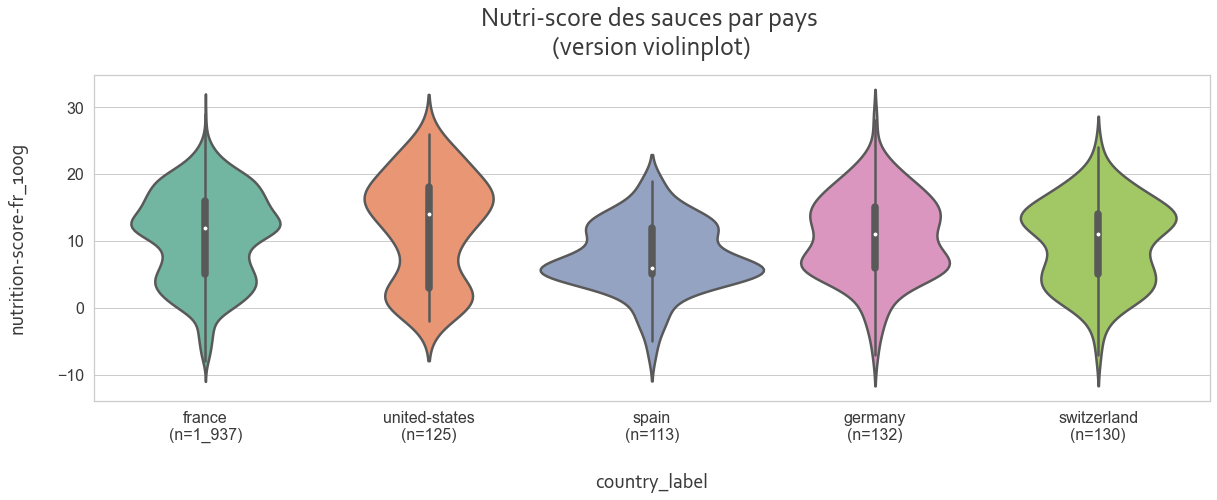

In [26]:
toolbox.plot_violinplot(country_df,
                        'nutrition-score-fr_100g',
                        'Nutri-score des sauces par pays \n(version violinplot)',
                        (20, 6),
                        'country_label')

Pour que les r√©sultats de l'ANOVA soient fiables nos donn√©es doivent valider les hypoth√®ses suivantes:

- ind√©pendance intra et inter √©chantillons
- √©galit√© des variances (test de Bartlett)
- normalit√© des erreurs exp√©rimentales/r√©sidus (test de Shapiro-Wilk)

1) Ind√©pendance des √©chantillons 

Seul le contexte de l‚Äô√©tude permet de s‚Äôassurer de l‚Äôind√©pendance entre les √©chantillons de chaque groupe. 

Il est possible qu'un m√™me produit soit vendu dans plusieurs pays et donc pr√©sent dans plusieurs √©chantillons, qu'une m√™me marque ait fabriqu√© plusieurs produits diff√©rents (en utilisant des ingr√©dients similaires) ... 

On ne sait pas si l'hypoth√®se d'ind√©pendance est v√©rifi√©e.

2) Egalit√© des variances

L‚Äôamplitude des bo√Ætes des boxplots traduit graphiquement l‚Äô√©galit√© ou non des variances. Graphiquement il semblerait que nos variances ne soient pas √©gales. 

In [59]:
country_df.groupby("country")['nutrition-score-fr_100g'].agg('var')

country
france          45.65
germany         37.96
spain           25.28
switzerland     37.58
united-states   59.74
Name: nutrition-score-fr_100g, dtype: float64

Le test de bartlett permet de tester si les variances sont significativement diff√©rentes ou non.

- H0 : Les variances de chaque groupe sont √©gales 
- H1 : Les variances de chaque groupe ne sont pas toutes √©gales

Niveau de test 1%

In [69]:
st.bartlett(*[group['nutrition_score_fr_100g'].values for name, group in country_df.groupby("country")])

BartlettResult(statistic=24.77124654702316, pvalue=5.5928188824707197e-05)

p_value < 0.01 -> On peut largement rejeter H0, les variances ne sont pas toutes √©gales.

On pourrait s'arreter l√† pour rejeter l'ANOVA, mais on va quand m√™me regarder la distribution des r√©sidus (pour l'exercice).

3) Normalit√© des r√©sidus

L‚Äôobjectif est de s‚Äôassurer que les r√©sidus suivent une loi normale afin de ne pas affirmer qu‚Äôil existe une diff√©rence de moyenne entre les groupes qui serait caus√©e par le hasard.

On utilise le test de Shapiro-Wilk

- H0 : Les r√©sidus suivent une loi normale
- H1 : Les r√©sidus ne suivent pas une loi normale

Niveau de test 1%

In [65]:
country_df.rename(columns={'nutrition-score-fr_100g': 'nutrition_score_fr_100g'}, inplace=True)
model = ols('nutrition_score_fr_100g ~ country', data=country_df).fit()
st.shapiro(model.resid)

ShapiroResult(statistic=0.9834931492805481, pvalue=3.238112724937808e-16)

p_value < 0.01 -> on rejette tr√®s largement H0, les r√©sidus ne suivent pas une loi normale. 

Aucune des conditions pour effectuer une ANOVA n'est valid√©e. Il n'est donc pas conseill√© de l'utiliser car les r√©sultats ne seraient pas fiables.
On va donc utiliser une alternative non-param√©trique, le test de Kruskal-Wallis (un test robuste qui s'applique √† la m√©diane). Il n'y a pas besoin de remplir des conditions pr√©alables pour l'appliquer. 

Test de Kruskal-Wallis: 

- H0 : Le pays n'a aucune influence sur la valeur nutritionnelle du produit (√©galit√© des m√©dianes)
- H1 : Le pays influe sur la valeur nutritionnelle du produit . (Une m√©diane s'√©carte significativement des autres)

Niveau de test : 1%

In [70]:
st.kruskal(*[group['nutrition_score_fr_100g'].values for name, group in country_df.groupby("country")])

KruskalResult(statistic=32.673263805018955, pvalue=1.393335299972153e-06)

p_value < 0.01 donc on peut largement rejeter H0, le facteur g√©ographique aurait √† priori un impact sur la valeur nurtritionnelle des produits

***

***

<h4 style="font-family:Corbel Light; color:#e54b87">Variable quantitative vs quantitative</h4>

On va regarder la relation entre les composantes du nutriscore 2 √† 2

In [30]:
'{:_}'.format(food_data.shape[0])

'235_562'

In [31]:
food_data_sample = resample(food_data, random_state=0, n_samples=1000)

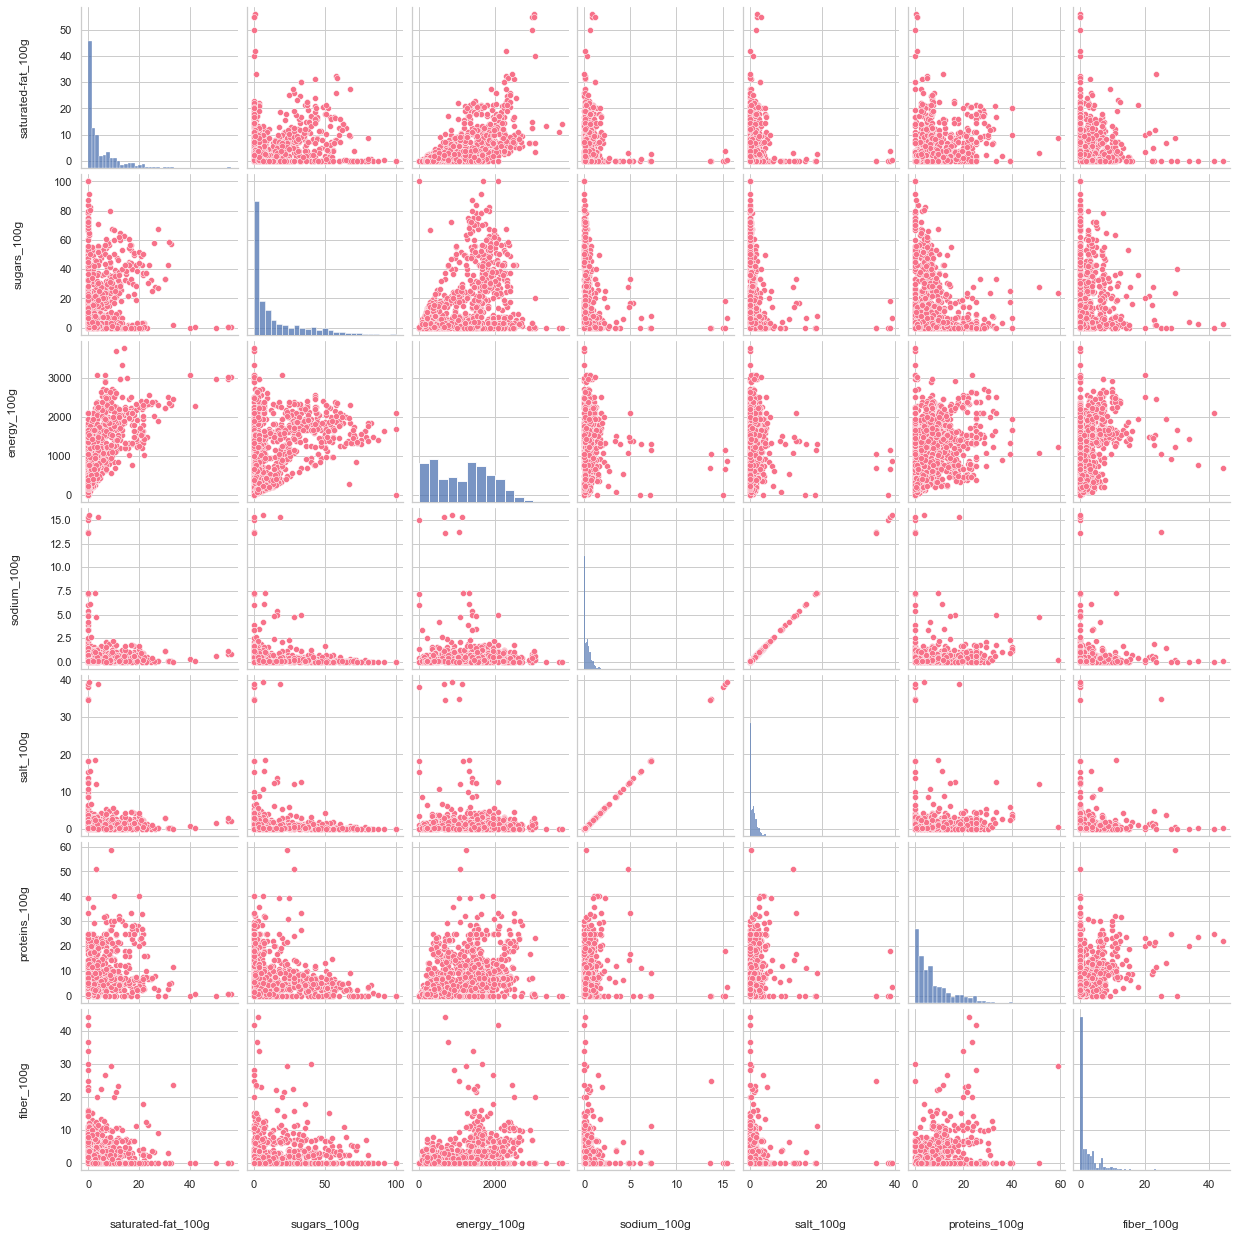

In [32]:
color = sns.color_palette("husl", 8)[0]

sns.pairplot(food_data_sample,
             vars=columns_100g,
             plot_kws=dict(color=color),
             dropna=True)

Matrice de corr√©lation

In [33]:
correlation_matrix = food_data[columns_100g].corr()

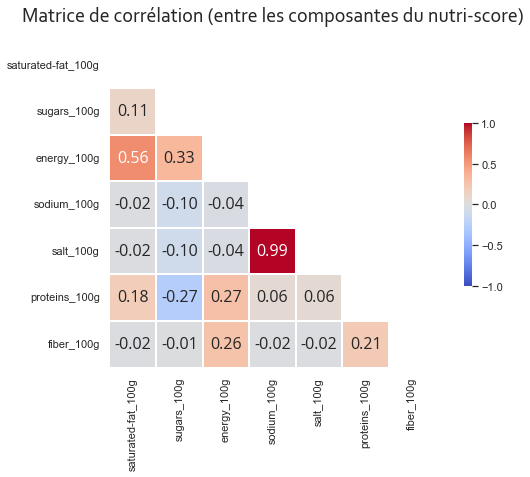

In [34]:
toolbox.plot_heatmap_correlation_matrix(correlation_matrix,
                                        'Matrice de corr√©lation (entre les composantes du nutri-score)',
                                        (10, 6),
                                        'coolwarm')

<h3 style="font-family:Corbel Light; color:#737373">Analyse en composantes principales</h3>

In [35]:
nutrients = toolbox.get_columns_contains(food_data, '_100g', ['nutrition-score-fr_100g', 'sodium_100g'])
X = food_data[nutrients]

In [36]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

pca = PCA(n_components=len(nutrients))
X_proj = pca.fit_transform(X_scaled)

<h4 style="font-family:Corbel Light; color:#e54b87"">Eboulis des valeurs propres</h4>

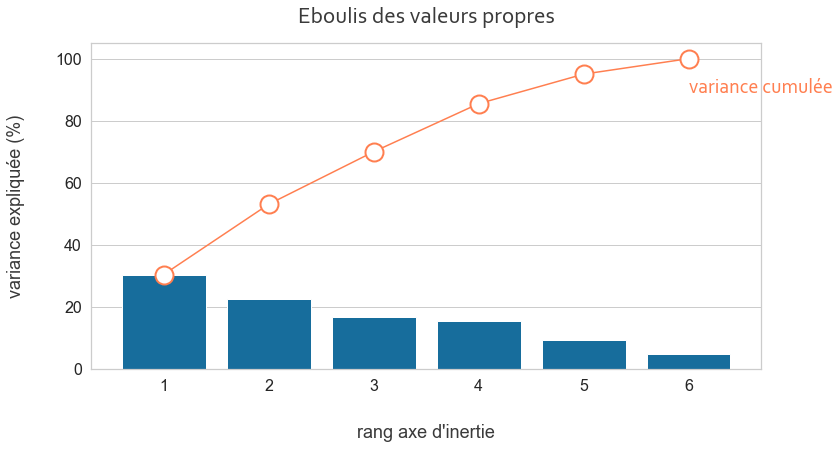

In [37]:
titles = {'chart_title': 'Eboulis des valeurs propres',
          'x_label': 'rang axe d\'inertie',
          'y_label': 'variance expliqu√©e (%)'}

toolbox.plot_screeplot(pca,
                       len(nutrients),
                       (12, 6),
                       titles,
                       sns.desaturate(sns.color_palette('colorblind')[0], 0.75)
                       )

***

***

<h4 style="font-family:Corbel Light; color:#e54b87">Composantes</h4>

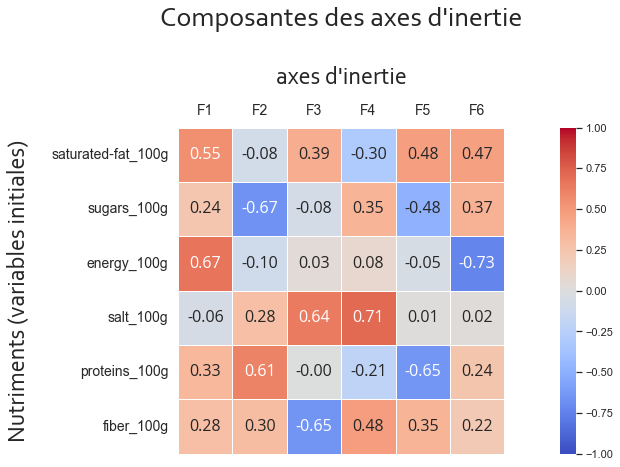

In [38]:
pcs_df = pd.DataFrame(data=pca.components_,
                      index=['F' + str(s) for s in range(1, len(nutrients) + 1)],
                      columns=nutrients)
titles = {'chart_title': 'Composantes des axes d\'inertie',
          'y_title': 'Nutriments (variables initiales)',
          'x_title': 'axes d\'inertie'}

toolbox.plot_heatmap(pcs_df.T, 1, titles, (20, 6),
                     "0.2f", True, -1, 'coolwarm', True)

***

***

<h4 style="font-family:Corbel Light; color:#e54b87">Cercle des corr√©lations</h4>

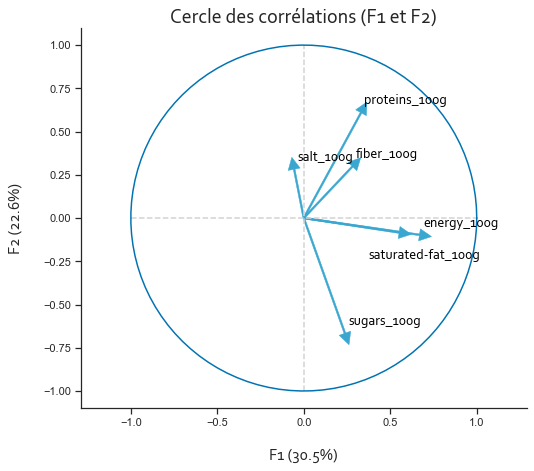

In [39]:
toolbox.plot_correlation_circle(pca, 0, 1, (8, 7), nutrients, sns.color_palette('husl', 8)[5])

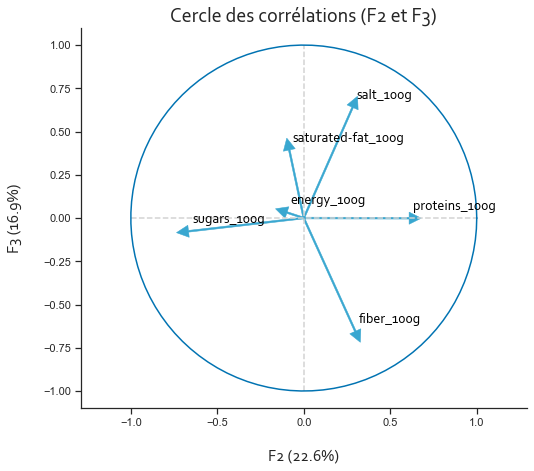

In [40]:
toolbox.plot_correlation_circle(pca, 1, 2, (8, 7), nutrients, sns.color_palette('husl', 8)[5])

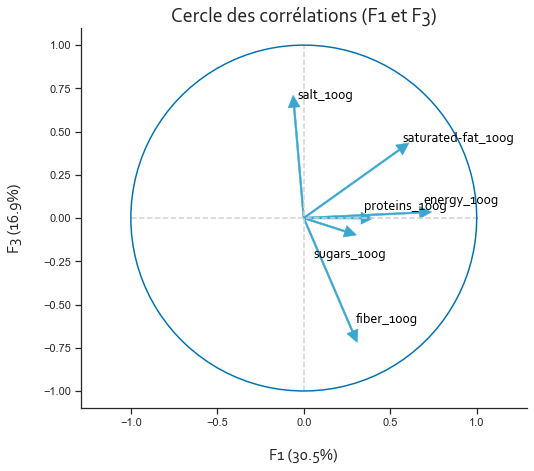

In [41]:
toolbox.plot_correlation_circle(pca, 0, 2, (8, 7), nutrients, sns.color_palette('husl', 8)[5])

F1 : positivement corr√©l√© avec les acides gras satur√©s et l'√©nergie -> Facteur √©nerg√©tique 
(coefficient de correlation lin√©aire entre √©nergie et acides gras satur√©s = 0.56 comme vu dans la matrice de corr√©lation)

F2 : anticorr√©l√© avec sucre et positivement corr√©l√© avec les prot√©ines -> aliments riches en prot√©ines et peu sucr√©s 
(coefficient de correlation lin√©aire entre sucre et prot√©ines = -0.27 comme vu dans la matrice de corr√©lation)

F3 : anticorr√©l√© avec fibres et positivement corr√©l√© avec le sel - > aliments sal√©s et faibles en fibres 
(coefficient de correlation lin√©aire entre sel et fibres = -0.02 comme vu dans la matrice de corr√©lation)

***

***

<h4 style="font-family:Corbel Light; color:#e54b87">Projection du nuage des individus dans un plan factoriel</h4>

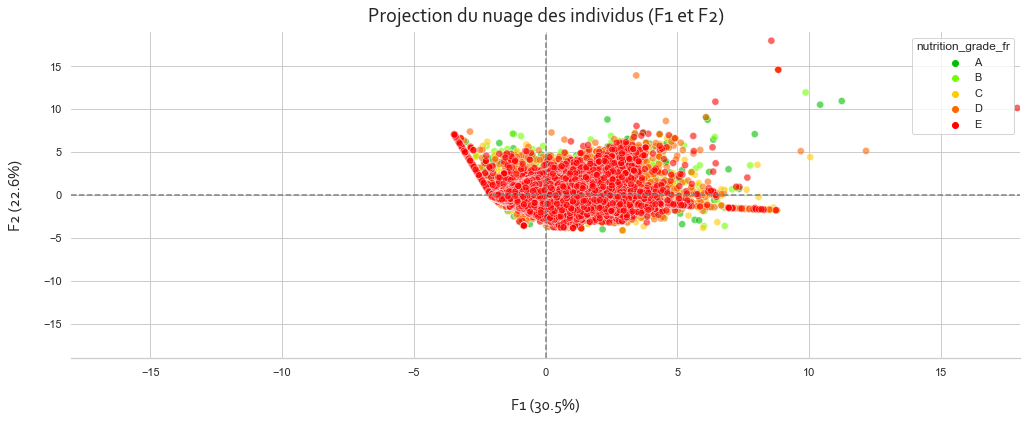

In [42]:
X_proj_df = toolbox.display_pca_scatterplot(pca, 0, 1, X_proj,
                                            len(nutrients), (17, 6), True,
                                            food_data['nutrition_grade_fr'],
                                            palette_nutriscore
                                            )

On y voit pas grand chose

On aurait pu essayer de faire un clustering et n'afficher que les centres de gravit√© des groupes

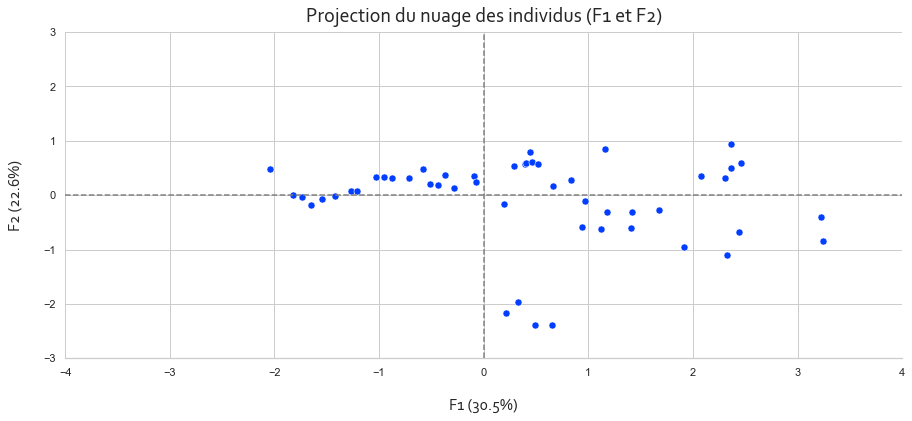

In [43]:
kmeans = KMeans(n_clusters=50)
kmeans.fit(X.values)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
food_data['labels'] = labels

centroids_scaled = scaler.transform(centroids)
centroids_proj = pca.transform(centroids_scaled)

centroid_proj_df = toolbox.display_pca_scatterplot(pca, 0, 1, centroids_proj, len(nutrients), (15, 6))

In [44]:
centroid_proj_df.sort_values(['F1', 'F2'], ascending=False).head()

F1    F2    F3    F4   F5    F6
10 3.24 -0.85  1.41 -1.07 1.91 -1.70
5  3.22 -0.41  1.39 -1.03 2.07 -0.57
35 2.46  0.59 -0.04 -0.16 0.26 -0.61
23 2.44 -0.67  0.96 -0.72 1.38 -1.85
27 2.36  0.94 -0.44  0.06 0.04 -0.49

Q1 : Diff√©rence entre les individus avec une abscisse (i.e. F1) grande et ceux avec une abscisse petite : valeur √©nerg√©tique
- centroid avec une abscisse √©lev√©e (4.04) : aliments avec une valeur √©nerg√©tique √©lev√©e et plut√¥t gras (entre 3 029Kj et 3 234Kj avec mediane = 3 067Kj) (ex: beurre, cookie dough, mayo)
- centroid avec une abscisse faible (-2.04) : aliments avec une valeur √©nerg√©tique faible (entre 0Kj et 46Kj avec mediane = 9Kj) (ex: fruits/l√©gumes, caf√©, bouillon de poulet)

Q2 : Diff√©rence entre 2 individus avec la m√™me abscisse (F1) mais des ordonn√©es (F2) diff√©rentes : quantit√© de sucre
- centroid avec x=0.65 et y=-1.99 : aliments √† haute valeur √©nerg√©tique (1615Kj/1700Kj) et plut√¥t sucr√©s (entre 38g et 100g avec m√©diane=68g) (muesli avec fruits, c√©r√©ales pour le petit dej, barres de c√©r√©ales, brownies ...)
- centroid avec x=0.63 et y=0.43 : aliments √† haute valeur √©nerg√©tique  (1519Kj/1590Kj) mais peu sucr√©s (entre 0g et 52g avec m√©diane = 3.5g)(graines de lin, de chia, tortillas chips)

Q3: Diff√©rence entre 2 individus avec composantes similaires pour F1 et F2 mais tr√®s diff√©rentes pour F3 : quantit√© de fibres

difficile √† voir avec les centroids
- individu avec 7.36/0.97 et -0.96 : p√©tales de coco non-sucr√©s (valeur √©nerg√©tique √©lev√©e (3 067Kj) tr√®s riche en fibres (26.70g)
- individu avec 7.34/0.74 et 2.48  : amandes en poudre (m√™me type de produit valeur √©nerg√©tique √©lev√©e (2 570Kj), peu sucr√© (5.50g)) mais moins de fibres (9.40g))

<h2 style="font-family:Corbel Light; color:#737373"><span style="color:#e54b87">√âtape 3</span> : Pr√©sentation de l'id√©e d'application</h2>

- l'utilisateur entre le code-barres de son produit, 
- l'application lui propose des produits de la m√™me cat√©gorie mais avec un meilleur nutriscore et le moins d'additifs possible

Rmq : l‚Äòapproche bag of words est utilis√©e pour s√©lectionner les produits avec un nom similaire au produit initial. 

In [45]:
food_data_app = food_data.loc[mask_gp2].copy()
palette_nutriscore_dict = {'A': '#00BF00',
                           'B': '#73FF00',
                           'C': '#FFCC00',
                           'D': '#FF6600',
                           'E': '#FF0000'}

On g√©n√®re une liste de codes-barres pour tester l'application (on peut aussi essayer de rentrer des faux codes-barres)

*Remarque: les premiers codes-barres correspondent √† des nutri-grades A*

In [46]:
n_samples = 20
codes = food_data_app.groupby('nutrition_grade_fr',
                              group_keys=False).apply(lambda x: x.sample(min(len(x), math.ceil(n_samples/5))))['code']
list(codes.values)

[3580281070154.0,
 3560070208852.0,
 3564700008812.0,
 3660992000395.0,
 8859015700038.0,
 8715700061009.0,
 3564700459447.0,
 3023290719848.0,
 3560070419968.0,
 3564700559307.0,
 3270160646326.0,
 3760061027299.0,
 3760133470008.0,
 3350033086951.0,
 8480017089373.0,
 3760083785337.0,
 3256760003219.0,
 3425850016006.0,
 8593893720589.0,
 4000161470779.0]

Faire tourner la cellule de code ci-dessous pour tester l'application : 

Veuillez entrer le code-barres:  3242611000032.0


Ce code barre correspond √† : Sirop de Grenadine - NutriScore E
Recherche de meilleures alternatives üßê 



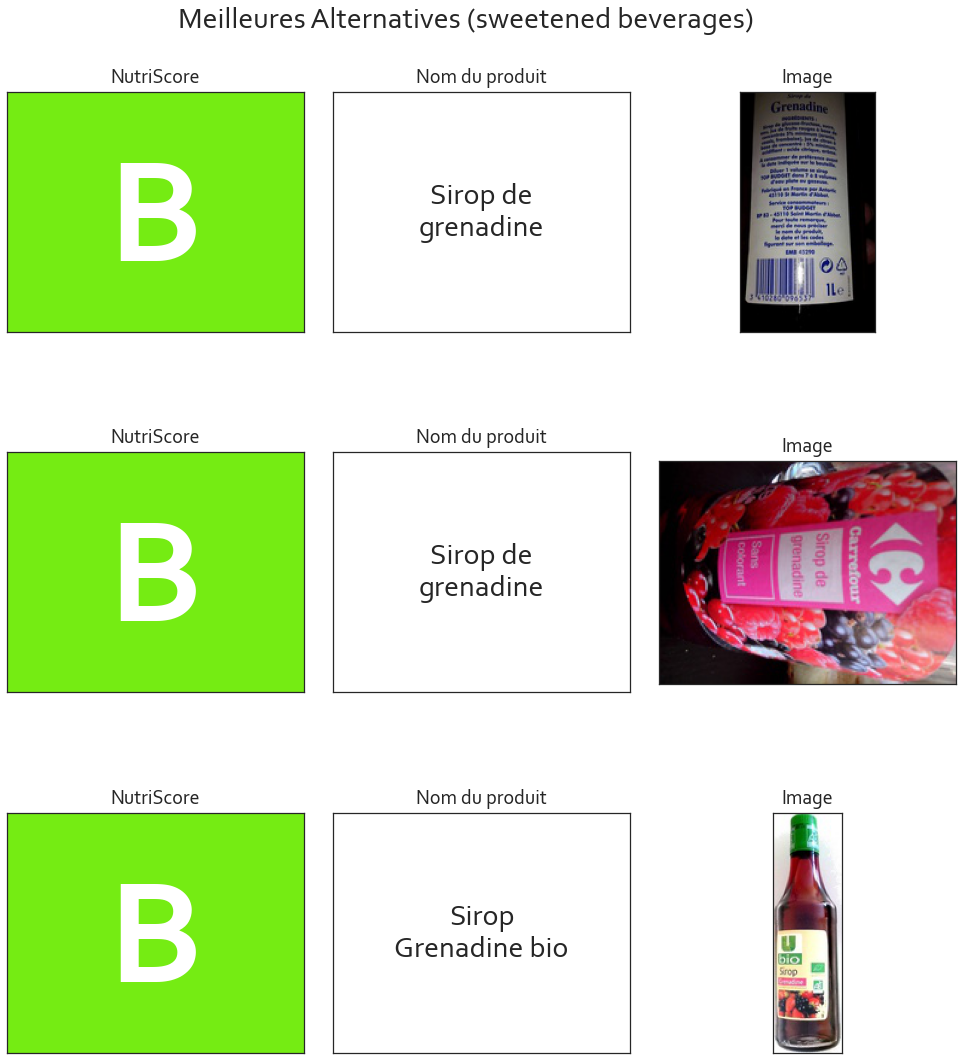

In [49]:
toolbox.application_nutriscore(food_data_app, 3,
                               palette_nutriscore_dict,
                               'code', 'pnns_groups_2',
                               'nutrition_grade_fr', 'additives_n',
                               'product_name', 'image_small_url'
                               )

<h2 style="font-family:Corbel Light; color:#737373"><span style="color:#e54b87">Conclusion</span></h2>

Concernant la qualit√© des donn√©es :
- Les donn√©es sont assez anciennes et essentiellement am√©ricaines alors qu‚Äôon vise un public fran√ßais. 
- Il manque des donn√©es pour beaucoup de variables (ex: image, marque, ingr√©dients) 
- Le nettoyage est difficile : il s'agit d'un jeu rempli par des b√©n√©voles, il peut donc y avoir des erreurs voire des donn√©es "trolls" i.e. certaines personnes ont fait expr√®s de remplir n'importe quoi. En effet, certains produits ne sont pas de la nourriture (DVD ‚Äì cordes de guitare ‚Äì cr√®me pour les mains) mais des quantit√©s de sucres, sels etc ... ont √©t√© renseign√©es. 

De plus nous sommes limit√©s dans la r√©alisation de notre application :
- On n'a pas d‚Äôindicateur du degr√© de transformation des aliments dans ce jeu de donn√©es. J'avais √©galement envisag√© d'√©toffer l‚Äôapplication avec des crit√®res √©cologiques et/ou bio pour aider les utilisateurs √† consommer des produits fabriqu√©s pr√®s de chez eux, bio de pr√©f√©rence. On voit bien qu‚Äôil n‚Äôy a pas de variables suffisamment renseign√©es √† ce sujet dans ce jeu de donn√©es. 

Sur une note plus positive, on a r√©ussi √† isoler un sous ensemble de donn√©es coh√©rent pour faire tourner notre fonction "prototype". De plus ce projet m'a permis d‚Äôapprendre beaucoup de choses, notamment d‚Äôavoir un premier aper√ßu de ce que peut √™tre le machine learning. 